In [ ]:
# Комар Софія | завдання 4 - Transfer learning & Fine-tuning

# https://github.com/soviio/komar_sofiia_deep_learning/tree/main

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score
import os
import shutil
from PIL import Image
import torch.optim as optim
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision import models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# GPU
print("CUDA:", torch.cuda.is_available())

CUDA: True


**завантаження і підготовка даних**

In [5]:
# з минулої домашки

data_dir = "/content/drive/MyDrive/seg_train/seg_train"
test_dir = "/content/drive/MyDrive/seg_test/seg_test"

def is_valid_file(path):
    return ".ipynb_checkpoints" not in path.lower()

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(CustomImageFolder, self).__getitem__(index)
        except (OSError, IOError) as e:
            print(f"Error with image {self.imgs[index][0]}: {e}")
            return None

train_dataset = CustomImageFolder(root=data_dir, transform=transform, is_valid_file=is_valid_file)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform, is_valid_file=is_valid_file)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"К-сть train-зразків -> {len(train_data)}")
print(f"К-сть validation-зразків -> {len(val_data)}")
print(f"К-сть test-зразків -> {len(test_dataset)}")

for images, labels in train_loader:
    print(f"Батч розміру {images.size()}, мітки: {labels}")
    break

К-сть train-зразків -> 11227
К-сть validation-зразків -> 2807
К-сть test-зразків -> 3000
Батч розміру torch.Size([32, 3, 150, 150]), мітки: tensor([1, 3, 1, 4, 4, 0, 4, 2, 2, 3, 1, 5, 1, 3, 3, 2, 4, 5, 3, 2, 0, 3, 0, 0,
        4, 4, 1, 1, 3, 0, 2, 5])


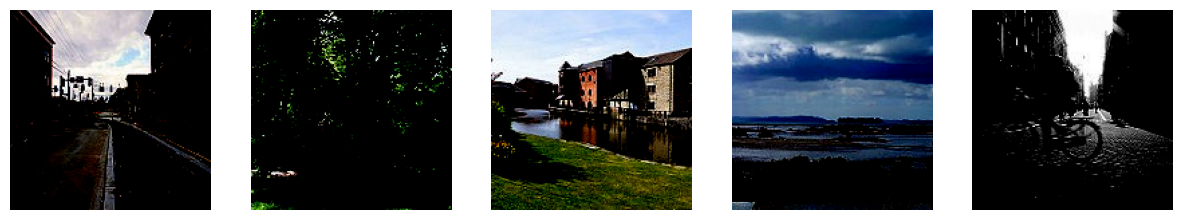

In [6]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].axis('off')
plt.show()

**1. Завантаження переднавченої моделі.**

Обираю ResNet50, вона потужна для завдань класифікації, добре працює з великим обсягом даних, оскільки виділяє важливі ознаки на різних рівнях мережі .

In [7]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

**2. Налаштування кількості вихідних класів.**

In [9]:
model.fc = torch.nn.Linear(model.fc.in_features, 6)

**3. Проведення донавчання моделі.**

In [10]:
def unfreeze_layers(model, epoch, total_epochs):

    layers_to_unfreeze = epoch + 1
    layers = list(model.children())
    num_layers = len(layers)

    # заморожуємо всі шари
    for param in model.parameters():
        param.requires_grad = False

    # розморожуємо шари поступово
    for i in range(layers_to_unfreeze):
        for param in layers[i].parameters():
            param.requires_grad = True

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

**аугментація**

In [12]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # горизонтальне віддзеркалення
    transforms.RandomRotation(45),  # обертання зображень
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),  # яскравість, контраст
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)
model = model.to(device)

In [16]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

num_epochs = 10
accuracies = []
f1_scores = []
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    true_labels = []
    predicted_labels = []
    unfreeze_layers(model, epoch, num_epochs)

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    scheduler.step()

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Epoch [1/10], Loss: 0.3904, Accuracy: 0.8592, F1 Score: 0.8602
Epoch [2/10], Loss: 0.3756, Accuracy: 0.8670, F1 Score: 0.8678
Epoch [3/10], Loss: 0.3698, Accuracy: 0.8708, F1 Score: 0.8718
Epoch [4/10], Loss: 0.3633, Accuracy: 0.8754, F1 Score: 0.8761
Epoch [5/10], Loss: 0.3531, Accuracy: 0.8751, F1 Score: 0.8759
Epoch [6/10], Loss: 0.3223, Accuracy: 0.8873, F1 Score: 0.8878
Epoch [7/10], Loss: 0.3013, Accuracy: 0.9007, F1 Score: 0.9009
Epoch [8/10], Loss: 0.2648, Accuracy: 0.9095, F1 Score: 0.9096
Epoch [9/10], Loss: 0.2436, Accuracy: 0.9165, F1 Score: 0.9164
Epoch [10/10], Loss: 0.2289, Accuracy: 0.9204, F1 Score: 0.9203


In [ ]:
# доречно зауважити, що при першому запуску коду вище спочатку точність була 30%
# і поступово зростала до 84% (при 10 епохах)
# покращення точності після перезапуску - результат використання попередньо навчених
# ваг (точність зросла до 92% при тих самих 10 епохах)

**4. Оцінка.**

In [17]:
# оцінюємо, наскільки добре модель виконує класифікацію на валідаційному наборі:
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

validation_accuracy = accuracy_score(true_labels, predicted_labels)
validation_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Validation Accuracy: {validation_accuracy:.4f}, Validation F1 Score: {validation_f1:.4f}")

Validation Accuracy: 0.9109, Validation F1 Score: 0.9106


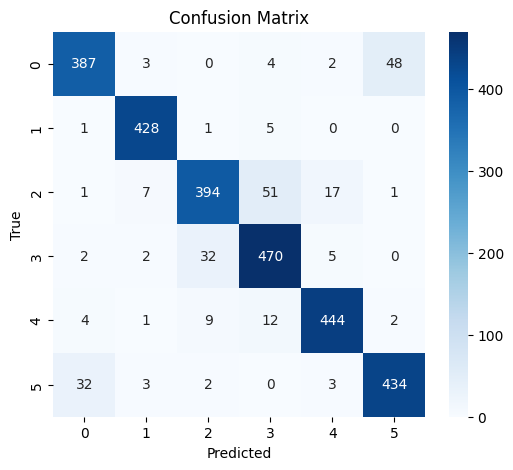

In [20]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

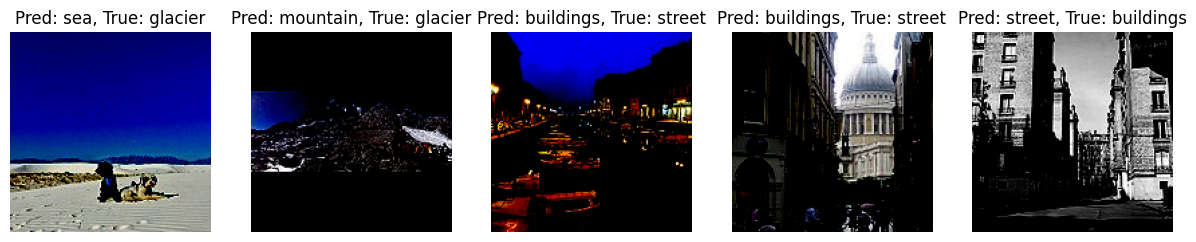

In [23]:
import random

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

wrong_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        incorrect = (predicted != labels)
        wrong_predictions.extend([(images[i], predicted[i], labels[i]) for i in range(len(labels)) if incorrect[i]])

random.shuffle(wrong_predictions)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img, pred, true = wrong_predictions[i]
    img = img.cpu().permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Pred: {class_names[pred.item()]}, True: {class_names[true.item()]}')

plt.show()

**ВИСНОВКИ:**

* Моделька класифікує більшість зображень правильно (точність ~91%). Основна діагональ матриці плутанини відображає правильні класифікації, інші елементи — це помилки класифікації.

* Моя модель має помилки між наступними подібними класами: glacier помилково класифікує як sea, street іноді плутається з buildings - мають схожий ландшафт (виведення вище явно демонструє схожіть місцевостей, чим і пояснюються ці похибки). Також умови освітлення впливають на плутанини зазначені вище.

* Загалом, порівнюючи з результатами реалізації попередніх домашок, можна помітити покращення результатів і зменшення плутанини між визначенням класів. Минулого разу точність була 80% на валідаційному наборі. Наразі ж вийшло покращити ситуацію без перенавчання.

* Застосування fine-tuning підвищило точність, але для покращення результатів моделі можна покращити стійкість до змін освітлення місцевостей.



In [24]:
torch.save(model.state_dict(), 'model_best.pth')

In [ ]:
# model = models.resnet50(pretrained=False)
# model.load_state_dict(torch.load('model_best.pth'))
# model.eval()